Linearization to get model in form:
$\Delta\dot{x} = A \Delta x + B \Delta u$

In [1]:
from IPython.display import display as disp
from IPython.display import Markdown as dispmd
from IPython.display import Latex as dispLtx
from sympy import symbols, cos, sin
import sympy as smp
import numpy as np
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
init_vprinting() 

In [2]:
Mt, Jt, m, L, g, gamma, d, Ff = smp.symbols('M_t J_t m L g gamma d F_f')
t = smp.symbols('t')
the, xw, Fi = smp.symbols('theta, x_w, F_i', cls=smp.Function)
the = the(t)
xw = xw(t)
Fi = Fi(t)
Dthe = smp.diff(the, t)
DDthe = smp.diff(the, t, 2)
Dxw = smp.diff(xw, t)
DDxw = smp.diff(xw, t, 2)
alpha = smp.symbols('alpha') 
beta = smp.symbols('beta')
v = smp.symbols('v')

''' Implicit equations '''
a1 = smp.Matrix([ 
    [Mt, m*L*cos(the)],
    [m*L*cos(the), Jt]
])
a2  = smp.Matrix([
    [DDxw],
    [DDthe]
])
a3 = smp.Matrix([
    [Ff - L*m*sin(the)*Dthe**2],
    [gamma*Dthe - m*g*L*sin(the)]
]) 
a4 = smp.Matrix([
    [-Fi],
    [0]
])
a5 = smp.Matrix([
    [-d*cos(the)],
    [-2*L*d]
])

DDxw_ss, DDthe_ss = a1.inv() * (-a3 - a4 - a5)
DDxw_ss = DDxw_ss.simplify()
DDthe_ss = DDthe_ss.simplify()

x1, x2, x3, x4 = smp.symbols('x_1 x_2 x_3 x_4', cls=smp.Function)
x1 = x1(t); x2 = x2(t); x3 = x3(t); x4 = x4(t) 
state_vec = smp.Matrix([
    [x1],
    [x2],
    [x3],
    [x4]
])
state_equations = smp.Matrix([
    [Dxw],
    [Dthe],
    [DDxw_ss],
    [DDthe_ss]
])
state_equations = state_equations.subs([(Dxw, x3), (Dthe, x4), (xw, x1), (the, x2)])
Fi_model = alpha*v - beta*x3
state_equations = state_equations.subs(Fi, Fi_model)

In [3]:
b = smp.symbols('b')
uc, us, vs = smp.symbols('mu_c mu_s v_s')
Ff_b = b*Dxw
Ff_s = (uc + (us - uc) * smp.exp(-(Dxw/vs)**2)) * Mt*g * smp.sign(Dxw) + b*Dxw

# stribeck friction, sign(Dx) ->np.-> tanh(500*Dx)
uc, us, vs = smp.symbols('mu_c mu_s v_s')
Ff_s2 = (uc + (us - uc) * smp.exp(-(Dxw/vs)**2)) * Mt*g * smp.tanh(600*Dxw) + b*Dxw

In [4]:
state_equations_visc = state_equations.subs(Ff, Ff_b).subs(Dxw, x3)
state_equations_stri = state_equations.subs(Ff, Ff_s2).subs(Dxw, x3)

In [5]:
Sg = [0, 0, 0, 0, 0, 0]
Sd = [0, np.pi, 0, 0, 0, 0]
S0 = [x1, x2, x3, x4, v, d]

In [6]:
# Zmienne przyrostowe
D_v, D_d = smp.symbols(r'\Delta{v} \Delta{d}')

D_x1, D_x2, D_x3, D_x4 = smp.symbols(r'\Delta{x_1} \Delta{x_2} \Delta{x_3} \Delta{x_4}')
zmienne_przyrostowe = [D_x1, D_x2, D_x3, D_x4, D_v, D_d]

In [7]:
df_dx = state_equations_visc.jacobian(state_vec)
df_du = state_equations_visc.jacobian([v])
df_dD = state_equations_visc.jacobian([d])

<!-- ## 🛰️ <font color='White'> TARCIE LEPKI </font> -->
## 🛰️ Viscous friction

<!-- ### <b> <font color='White'> Tarcie lepkie, górne położenie </font> -->
### <b> Viscous friction, up position

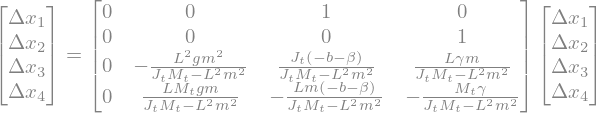

In [8]:
# Symbols for operating point
symb_val_dict = dict(zip(S0, Sg))
# Matrix A,
# A - macierz A, v - viscous, g - up
# etc.
A_v_g = df_dx.subs(symb_val_dict)
B_v_g = df_du.subs(symb_val_dict)
H_v_g = df_dD.subs(symb_val_dict)
state_vec_przyrostowe = smp.Matrix([[D_x1], [D_x2], [D_x3], [D_x4]])
ROWNANIE_STANU = smp.Eq(state_vec_przyrostowe, smp.MatMul(A_v_g, state_vec_przyrostowe, evaluate=False), evaluate=False)
ROWNANIE_STANU
# smp.MatMul(A_v_g, state_vec_przyrostowe).doit().simplify()

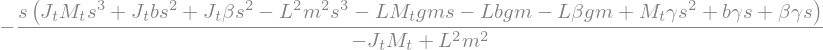

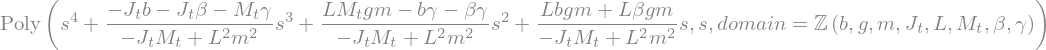

In [9]:
s = smp.Symbol('s')
r_char = smp.det(A_v_g - s*smp.eye(4))
# smp.roots(smp.Poly(r_char, s))
disp(r_char)
r_char_poly = smp.Poly(r_char, s)
disp(r_char_poly)

<!-- ### <b> <font color='white'> Viscous friction, down position </font> -->
### <b> Viscous friction, down position

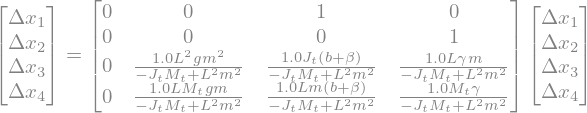

In [10]:
symb_val_dict = dict(zip(S0, Sd))
A_v_d = df_dx.subs(symb_val_dict)
A_v_d.simplify()
B_v_d = df_du.subs(symb_val_dict)
H_v_d = df_dD.subs(symb_val_dict)
state_vec_przyrostowe = smp.Matrix([[D_x1], [D_x2], [D_x3], [D_x4]])

ROWNANIE_STANU = smp.Eq(state_vec_przyrostowe,
                        smp.MatMul(A_v_d, state_vec_przyrostowe, evaluate=False),
                        evaluate=False)
ROWNANIE_STANU
# smp.MatMul(A_v_d, state_vec_przyrostowe).doit().simplify()

<!-- ## 🛰️ <font color='White'> TARCIE STRIBECKA </font> -->
## 🛰️ STRIBECK FRICTION

<!-- ### <b> <font color='White'> Tarcie stribecka, górne położenie </font> -->
### <b> Stribeck friction, up position

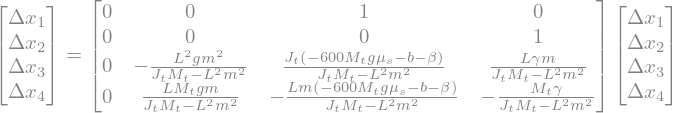

In [12]:
symb_val_dict = dict(zip(S0, Sg))
df_dx = state_equations_stri.jacobian(state_vec)
df_du = state_equations_stri.jacobian([v])
df_dD = state_equations_stri.jacobian([d])
A_s_g = df_dx.subs(symb_val_dict)
B_s_g = df_du.subs(symb_val_dict)
H_s_g = df_dD.subs(symb_val_dict)
state_vec_przyrostowe = smp.Matrix([[D_x1], [D_x2], [D_x3], [D_x4]])
ROWNANIE_STANU = smp.Eq(state_vec_przyrostowe, smp.MatMul(A_s_g, state_vec_przyrostowe, evaluate=False), evaluate=False)
ROWNANIE_STANU
# smp.MatMul(A_s_g, state_vec_przyrostowe).doit().simplify()

<!-- ### <b> <font color='White'> Tarcie stribecka, górne położenie </font> -->
### <b> Stribeck friciton, down position

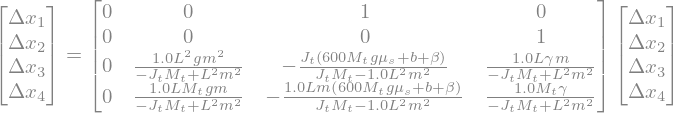

In [13]:
symb_val_dict = dict(zip(S0, Sd))
A_s_d = df_dx.subs(symb_val_dict)
B_s_d = df_du.subs(symb_val_dict)
H_s_d = df_dD.subs(symb_val_dict)
A_s_d.simplify()
state_vec_przyrostowe = smp.Matrix([[D_x1], [D_x2], [D_x3], [D_x4]])
ROWNANIE_STANU = smp.Eq(state_vec_przyrostowe, smp.MatMul(A_s_d, state_vec_przyrostowe, evaluate=False), evaluate=False)
ROWNANIE_STANU
# smp.MatMul(A_s_d, state_vec_przyrostowe).doit().simplify()